In [76]:
%load_ext autoreload
%autoreload 2

import sys
from copy import deepcopy
from sklearn.tree import export_text

sys.path.append('../..')
from viz import *
import viz
import imodels
from os.path import join as oj
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
from imodels.util.data_util import get_clean_dataset
from config.saps.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION
from sklearn.tree import DecisionTreeClassifier
from util import DATASET_PATH
print('num_datasets', len(DATASETS_CLASSIFICATION), len(DATASETS_REGRESSION))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
num_datasets 11 9


# overarching plots

In [77]:
def count_repeated_splits(m, model='SAPS', feat_thresh=0.01):
    if model == 'SAPS':
        feats = []
        threshes = []
        nodes = [root for root in m]
        while len(nodes) > 0:
            n = nodes.pop()
            feats.append(n.feature)
            threshes.append(n.threshold)
            if n.left is not None:
                nodes.append(n.left)
            if n.right is not None:
                nodes.append(n.right)
    elif model == 'CART':
        feats = m.feature
        threshes = m.threshold

    # count repeated splits
    n = len(feats)
    counts = np.zeros(n)
    for i in range(n):
        for j in range(n):
            if not i == j and feats[i] == feats[j] \
            and abs(threshes[i] - threshes[j]) <= feat_thresh:
                counts[i] += 1
    return np.sum(counts > 0) / n

In [88]:
num_dsets = 1
datasets = DATASETS_CLASSIFICATION[::-1][:3] #+ DATASETS_REGRESSION[::-1]

R, C = ceil(num_dsets / 3), 3
plt.figure(figsize=(3 * C, 2.5 * R), facecolor='w')

COLORS = [cb, cg, cr, 'gray', cp, 'green']
COLORS = COLORS + COLORS + COLORS
# plt.figure(figsize=(6, 3.6), dpi=150)
# for i, dset in enumerate(tqdm(datasets)):
r = {}
for dset in tqdm(datasets):
# dset = datasets[0]
    dset_name = dset[0]
    results = defaultdict(list)
    for seed in range(6):
        pkl_file = oj('../../results', 'saps', dset_name, f'train-test/seed{seed}/results_aggregated.pkl')
        data = pkl.load(open(pkl_file, 'rb'))  #['df']

        rules = data['df_rules']
        rules.index = np.arange(rules.shape[0])

        df = data['df']
        df.index = np.arange(df.shape[0])

        cols_to_use = df.columns.difference(rules.columns)
        d = rules.join(df[cols_to_use])

        # SAPS
        g = d[d.estimator == 'SAPS']
        name = 'SAPS'
        est_params = g[dset_name]
        trees = [x['trees_'] for x in est_params]
        n_trees = np.array([len(t) for t in trees])
        x = g['complexity'].values
        repeats = [count_repeated_splits(t, model='SAPS') for t in trees]
#         plt.plot(x, repeats, '.-', label='SAPS')
        results['x_saps'].append(x)
        results['repeats_saps'].append(repeats)

        # CART
        THRESH_REPEAT = 0.1
        g = d[d.estimator == 'CART']
        est_params = g[dset_name]
        trees = [x['tree_'] for x in est_params]
        repeats2 = [count_repeated_splits(t, model='CART') for t in trees]
        x2 = g['complexity'].values
#         plt.plot(x2, repeats2, '.-', label='CART')
        results['x_cart'].append(x2)
        results['repeats_cart'].append(repeats2)
    r[dset_name] = deepcopy(results)
    
# plt.legend(labelcolor='linecolor')
# dvu.line_legend(adjust_text_labels=True, extra_spacing=0.5)
# plt.grid(axis='y')
# plt.grid()
# plt.ylabel('Num repeats')
# plt.xlabel('Number of rules')
# plt.show()

100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


<Figure size 2250x625 with 0 Axes>

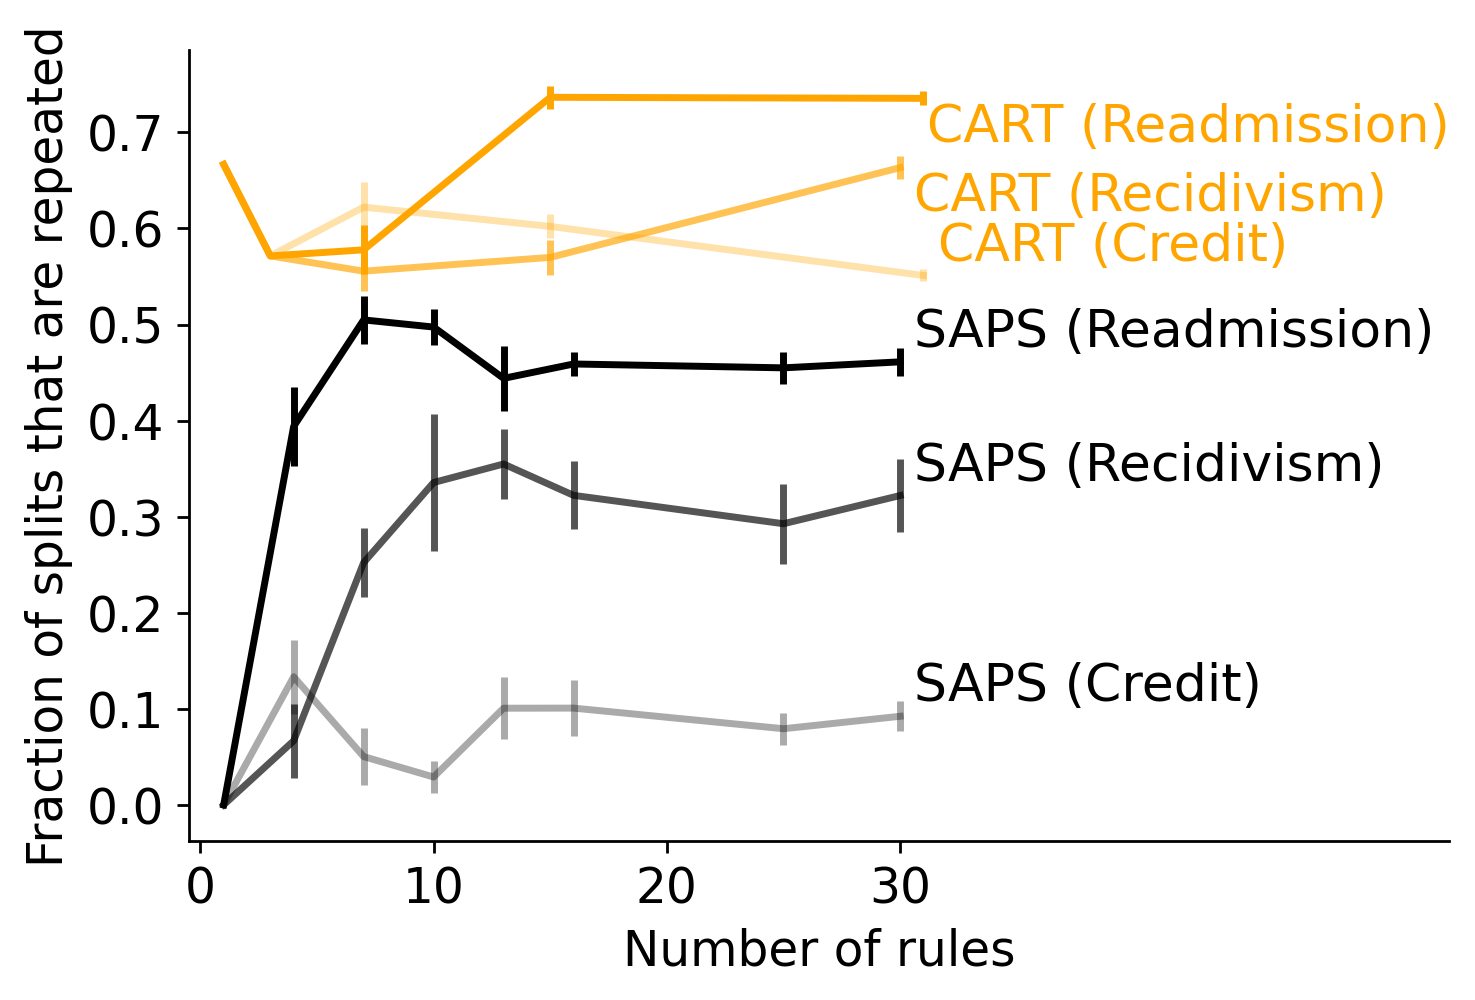

In [119]:
alphas = [1, 1/3, 2/3]
for i, dset_name in enumerate(r):
    df = pd.DataFrame.from_dict(r[dset_name])
#     plt.errorbar(df['x_saps'].values[0], np.vstack(df['repeats_saps'].values).mean(axis=0),
#                  yerr=np.vstack(df['repeats_saps'].values).std(axis=0) / np.sqrt(df.shape[0]), label='SAPS +', color='black')
#     plt.errorbar(df['x_cart'].values[0], np.vstack(df['repeats_cart'].values).mean(axis=0),
#                  yerr=np.vstack(df['repeats_cart'].values).std(axis=0) / np.sqrt(df.shape[0]), label='CART', color='orange')
    plt.plot(df['x_saps'].values[0], np.vstack(df['repeats_saps'].values).mean(axis=0), label=f'SAPS ({dset_name.capitalize()})', color='black', alpha=alphas[i], lw=2)
#                  yerr=np.vstack(df['repeats_saps'].values).std(axis=0) / np.sqrt(df.shape[0]), label='SAPS +', color='black')
    plt.plot(df['x_cart'].values[0], np.vstack(df['repeats_cart'].values).mean(axis=0), label=f'CART ({dset_name.capitalize()})', color='orange', alpha=alphas[i], lw=2)
#                  yerr=np.vstack(df['repeats_cart'].values).std(axis=0) / np.sqrt(df.shape[0]), label='CART', color='orange')
dvu.line_legend(adjust_text_labels=True, extra_spacing=0.75)

for i, dset_name in enumerate(r):
    df = pd.DataFrame.from_dict(r[dset_name])
    plt.errorbar(df['x_saps'].values[0], np.vstack(df['repeats_saps'].values).mean(axis=0),
                 yerr=np.vstack(df['repeats_saps'].values).std(axis=0) / np.sqrt(df.shape[0]),
                 color='black', lw=0, elinewidth=2, alpha=alphas[i])
    plt.errorbar(df['x_cart'].values[0], np.vstack(df['repeats_cart'].values).mean(axis=0),
                 yerr=np.vstack(df['repeats_cart'].values).std(axis=0) / np.sqrt(df.shape[0]),
                 color='orange', lw=0, elinewidth=2, alpha=alphas[i])

plt.xticks([0, 10, 20, 30], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Fraction of splits that are repeated', fontsize=14)
plt.xlabel('Number of rules', fontsize=14)
plt.tight_layout()
viz.savefig('repeated_splits')
plt.show()